In [8]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
import os
from time import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load the training dataset from Excel
trdf = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SC/New_shuffle.xlsx')
# trdf = pd.read_excel('/content/multichannel_bsentiment_train.xlsx')

# Load the testing dataset from Excel
tstdf = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SC/bala 1.xlsx')
# tstdf = pd.read_excel('/content/multichannel_bsentiment_test.xlsx')

# Convert 'very positive' to 'positive'
trdf['Tag'] = trdf['Tag'].replace('Very Positive', 1)
trdf['Tag'] = trdf['Tag'].replace('Positive', 1)
trdf['Tag'] = trdf['Tag'].replace('Neutral', 1)
trdf['Tag'] = trdf['Tag'].replace('Negative', 3)
trdf['Tag'] = trdf['Tag'].replace('Very Negative', 3)
trdf = trdf.drop(columns=['No'])

# Convert 'very negative' to 'negative'
tstdf['Tag'] = tstdf['Tag'].replace('Very Positive', 1)
tstdf['Tag'] = tstdf['Tag'].replace('Positive', 1)
tstdf['Tag'] = tstdf['Tag'].replace('Neutral', 1)
tstdf['Tag'] = tstdf['Tag'].replace('Very Negative', 3)
tstdf['Tag'] = tstdf['Tag'].replace('Negative', 3)

display(trdf)
display(tstdf)

,Comment,Tag
0,এই খুটি তে বাধার নিয়ম ইংরেজ চালু করেছিল তা এখন...,3
1,যারা জনগণের প্রতি দায়বদ্ধ তাদের দায়িত্ববোধ অনে...,1
2,"খেলার জন্যও মানুষ আপনাকে মনে রাখবে, জনগণের জন্...",1
3,বলে কি? সাব্বির কেন?? বাংলাদেশ ক্রিকেটের প্রতি...,3
4,দিন দিন ব‍্যংক এ আমানত কারিদের টাকা র উপর লাভ ...,3
...,...,...
6745,কেউ যদি উনাকে এক প্যাকেট বিস্কুট আর এক কাপ চা ...,3
6746,মান সন্মান না খোয়ালেই চলবে,1
6747,"আার এ জন্যই প্রয়োজন, নির্বাচনকালীন দল নিরপেক্ষ...",1
6748,কেন আপনার নেত্রীতো রাতেই উনার জরুরি সভা ডাকতেন...,3


,No,Comment,Tag
0,1,লিখার সময় পারলে সত্য লিখার অভ্যাস শিখুন।,3
1,2,"এই অর্জন আমাদের গর্ব, আমাদের অহংকার।",1
2,3,তাহলে এ থেকে পাবলিক কী শিক্ষা নিতে পারে!,3
3,4,"সিটিসেলের নাম ,কি আর কইতাম তারা আর কতই নাটক করবে?",3
4,5,শেয়ার প্রতি আয় কমেছে। শূন্য হয় নি এখনও। সরকারী...,3
...,...,...,...
3475,3476,সৈয়দ আশরাফের নির্লিপ্ততা একটা বড় কারন বলে মনে ...,1
3476,3477,আশা করি সরকার আনিসুল হক সাহেবের মত ভাল এক জন ...,1
3477,3478,ভাই সালটা হবে ২০৫০ । এর মধ্যে অনেকগুলি ফ্যাকট...,1
3478,3479,ক্রেডিট কার্ডের সুদের হারঃ-সিটি ব্যাংকের ৩৬%-ই...,1


In [10]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"
                           u"\u2000-\u206F"

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)
    return text

def remove_punctuations(my_str):

    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out
trdf['Comment'] = trdf.Comment.apply(lambda x: preprocessing(str(x)))
trdf.reset_index(drop=True, inplace=True)
display(trdf)

,Comment,Tag
0,এই খুটি তে বাধার নিয়ম ইংরেজ চালু করেছিল তা এখন...,3
1,যারা জনগণের প্রতি দায়বদ্ধ তাদের দায়িত্ববোধ অনে...,1
2,খেলার জন্যও মানুষ আপনাকে মনে রাখবে জনগণের জন্য...,1
3,বলে কি সাব্বির কেন বাংলাদেশ ক্রিকেটের প্রতি এট...,3
4,দিন দিন ব্যংক এ আমানত কারিদের টাকা র উপর লাভ ক...,3
...,...,...
6745,কেউ যদি উনাকে এক প্যাকেট বিস্কুট আর এক কাপ চা ...,3
6746,মান সন্মান না খোয়ালেই চলবে,1
6747,আার এ জন্যই প্রয়োজন নির্বাচনকালীন দল নিরপেক্ষ ...,1
6748,কেন আপনার নেত্রীতো রাতেই উনার জরুরি সভা ডাকতেন...,3


0


1    4050
3    2700
Name: Tag, dtype: int64

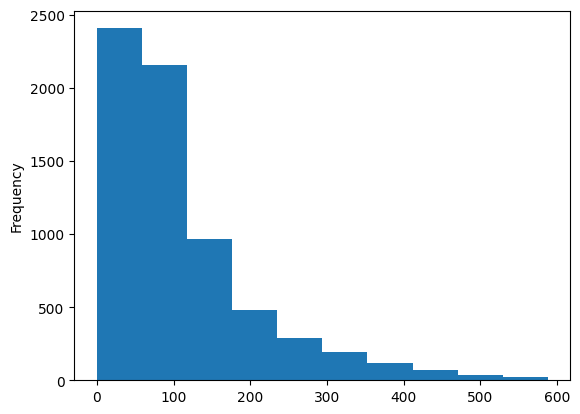

In [11]:
print(trdf.isna().sum().sum())
trdf['Comment'].apply(lambda x: len(str(x))).plot(kind='hist');
trdf.Tag.value_counts()

In [13]:
uniqueWords = list(set(" ".join(trdf['Comment']).split(" ")))
count = len(uniqueWords)
print("Unique Words : ",count)

Unique Words :  22322


In [ ]:
trdf['Comment'] = trdf['Comment'].astype('str')
trdf.reset_index(drop=True, inplace=True)
display(trdf.head())

In [15]:
from sklearn.utils import shuffle
trdf = shuffle(trdf)
display(trdf)

,Comment,Tag
5299,ভালো কথা সবাই বলে কিন্তু ইলেকশনে দাড়ালে দেখা য...,3
6380,এই ঘটনায় শুধু যে দুজন মরেছে তা নয় সামনে ধুকে ...,1
844,শা বাঁশ,1
6567,আমি লজ্জিত,3
2295,গ্রেনেড মেরে দিনদুপুরে পচিশতিরিশ জন মানুষ হত্য...,1
...,...,...
3811,কোনটা অপতৎপরতা আর কোনটা কি মানুষ জানেতনু মিতু ...,1
2201,মনে রাখা উচিৎ টাকা ছাড়া কিন্তু টাকা অস্মপুরন...,3
4176,মাশরাফি বিসিবির নিয়োগপ্রাপ্ত ও বেতন ভুক্ত একজন...,3
6030,ভয় পাইছেন এবার চিল্লায় চিল্লায় গান করেন,3


In [16]:
train1, test1 = train_test_split(trdf,random_state=42, test_size=0.2)
training_sentences = []
testing_sentences = []

train_sentences=train1['Comment'].values
train_labels=train1['Tag'].values

test_sentences=test1['Comment'].values
test_labels=test1['Tag'].values

train_labels=pd.get_dummies(train_labels).values
test_labels=pd.get_dummies(test_labels).values

print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 5400
Testing Set Length: 1350
training_sentences shape: (5400,)
testing_sentences shape: (1350,)
train_labels shape: (5400, 2)
test_labels shape: (1350, 2)


In [17]:
train_labels

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [18]:
print(train_sentences[0])
print(train_labels[0])

এখন মিয়ানমারকে বিশ্ব ধিক্কার দিচ্ছে এবং বাংলাদেশকে মানবিকতার কারণে সাধুবাদ
[1 0]


In [20]:
vocab_size = 22000
embedding_dim = 300
max_length = 600
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

In [22]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

19456
Word index length:19456


In [23]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

সব সময় হীনমন্যতায় ভোগা অসুখের লক্ষণ ডাক্তার দেখানো উচিৎ

Sentence Tokenized and Converted into Sequence :--> 

[47, 88, 7759, 7760, 7761, 1917, 1698, 1095, 200]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [24]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (5400, 600)
Padded shape(testing): (1350, 600)


In [25]:
from keras.layers import MaxPool1D
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(256, kernel_size=3, activation = "relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

#l2 regularizer
model.add(Dense(1000,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(2, activation='softmax'))

adam=Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          6600000   
                                                                 
 conv1d (Conv1D)             (None, 598, 256)          230656    
                                                                 
 max_pooling1d (MaxPooling1  (None, 299, 256)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 299, 256)          0         
                                                                 
 flatten (Flatten)           (None, 76544)             0         
                                                                 
 dense (Dense)               (None, 256)               19595520  
                                                        

In [27]:
history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/10
22/22 [==============================] - 164s 7s/step - loss: 4.4150 - accuracy: 0.5907 - val_loss: 4.0487 - val_accuracy: 0.5867
Epoch 2/10
22/22 [==============================] - 145s 7s/step - loss: 3.7583 - accuracy: 0.6033 - val_loss: 3.4496 - val_accuracy: 0.5867
Epoch 3/10
22/22 [==============================] - 143s 7s/step - loss: 3.2038 - accuracy: 0.6033 - val_loss: 2.9483 - val_accuracy: 0.5867
Epoch 4/10
22/22 [==============================] - 135s 6s/step - loss: 2.7320 - accuracy: 0.6033 - val_loss: 2.5282 - val_accuracy: 0.5867
Epoch 5/10
22/22 [==============================] - 141s 6s/step - loss: 2.2964 - accuracy: 0.6320 - val_loss: 2.1663 - val_accuracy: 0.6133
Epoch 6/10
22/22 [==============================] - 132s 6s/step - loss: 1.7764 - accuracy: 0.8731 - val_loss: 1.9359 - val_accuracy: 0.6356
Epoch 7/10
22/22 [==============================] - 133s 6s/step - loss: 1.2993 - accuracy: 0.9537 - val_loss: 1.8945 - val_accuracy: 0.6244
Epoch 8/10
22

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


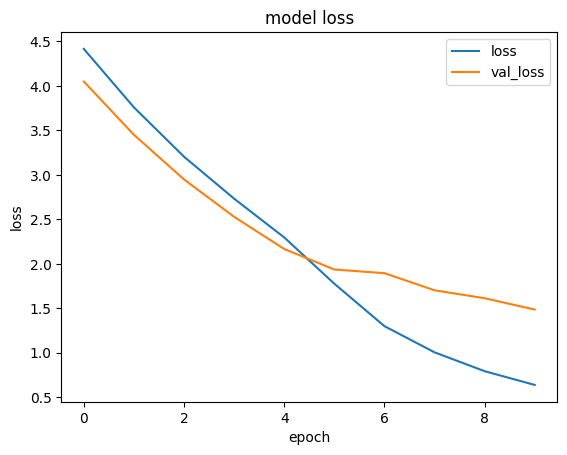

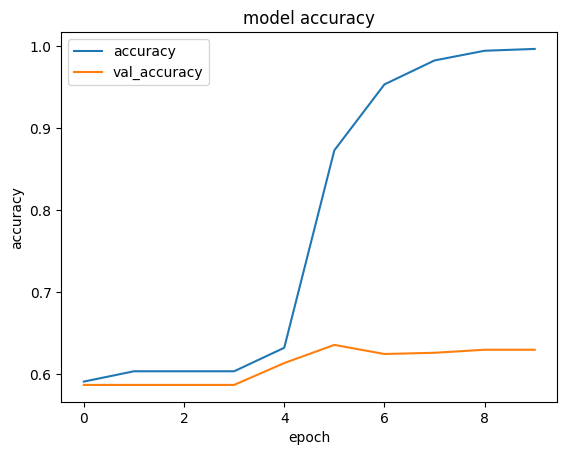

In [28]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [29]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

22/22 [==============================] - 33s 1s/step - loss: 0.5630 - accuracy: 0.9972
The train accuracy is: 0.9972222447395325
6/6 [==============================] - 8s 1s/step - loss: 1.4861 - accuracy: 0.6296
The test accuracy is: 0.6296296119689941


In [30]:
predictions = model.predict(testing_padded)
pred1 = np.argmax(predictions , axis=1)

43/43 [==============================] - 9s 205ms/step


In [31]:
score = model.evaluate(testing_padded, test_labels , batch_size = 256)
print()

print("ACCURACY:",score[1])
print("LOSS:",score[0])

6/6 [==============================] - 8s 1s/step - loss: 1.4861 - accuracy: 0.6296

ACCURACY: 0.6296296119689941
LOSS: 1.4860700368881226


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [33]:
test_labels = np.argmax(test_labels,axis=1)

In [34]:
print(confusion_matrix(test_labels , pred1 ,normalize=None))

[[582 210]
 [290 268]]


In [35]:
print(classification_report(test_labels , pred1))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       792
           1       0.56      0.48      0.52       558

    accuracy                           0.63      1350
   macro avg       0.61      0.61      0.61      1350
weighted avg       0.62      0.63      0.62      1350



In [36]:
accuracy_score(test_labels , pred1)

0.6296296296296297